## Text-based meta-analysis of functional brain dysconnectivity findings in psychopathology

### Import the relevant libraries

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import warnings
import math
import itertools

from nilearn import image
from nilearn import plotting
from itertools import combinations
from matplotlib.backends.backend_pdf import PdfPages

import importlib
import plotting_func as plot
importlib.reload(plot)

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
sns.set()

<module 'plotting_func' from 'C:\\Users\\smine\\OneDrive\\Documents\\GitHub\\TBMA\\visualization\\plotting_func.py'>

### Input Variables

In [59]:
target_atlas = 'CAB-NP_reordered'
matrices_folder_path = r'CAB-NP_reordered_input_cole12_n428_max'

stats_methods = ['fdr','unweighted']
alpha = 0.1

diagnosis_data = pd.read_csv(os.path.abspath(r'../input/diagnosis_data.csv'), index_col=0)
methods_data = pd.read_csv(os.path.abspath(r'../input/methods_data.csv'), index_col= 0 )
n_patients_BD = pd.read_csv(r'../input/n_BD.csv')
n_patients_SZ = pd.read_csv(r'../input/n_SZ.csv')
n_patients_MDD = pd.read_csv(r'../input/n_MDD.csv')
atlas_connections_size = pd.read_csv(r'../input/CAB-NP_connections_size.csv', index_col=0)

diagGroup = ['MDD', 'BD','SZ']
interacType = ['Tested','Hypoconnected','Hyperconnected']

diagColors = { 'MDD':'#2B5697', 'BD':"#007A62", 'SZ':'#CC0B2A'}
typeMarkers = {'Tested':'d','Hypoconnected':'v','Hyperconnected':'^'}

In [60]:
input_path = os.path.abspath(os.path.join(r'../results', matrices_folder_path))
fig_folder_path = os.path.join(input_path, 'figures')
if not os.path.exists(fig_folder_path):
    os.makedirs(fig_folder_path)

### Load and display atlas

In [61]:
# Load anatomical template and functional brain parcellations

atlas_path = os.path.abspath(r'../atlas')
anat = image.load_img('template_icbm_sym_09_white.nii.gz')
atlas = image.load_img(os.path.join(atlas_path,'atlas.nii.gz'.replace('atlas',target_atlas)))
atlas_info = pd.read_csv(os.path.join(atlas_path,'atlas.csv'.replace('atlas',target_atlas)), sep=';')
atlas_labels = dict(zip(atlas_info.iloc[:,1], atlas_info.iloc[:,2]))
atlas_labels_abb = list(atlas_labels.values())

<Figure size 1440x720 with 0 Axes>

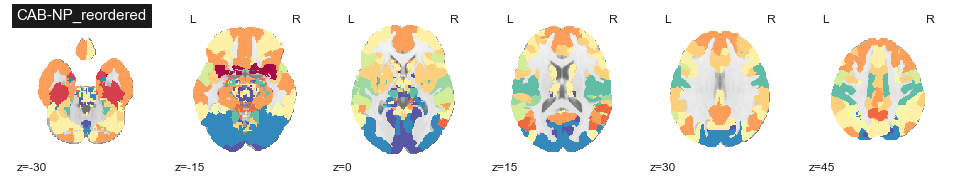

In [62]:
# Display Cole brain parcellation

fig = plt.figure(figsize=(20,10))


display = plotting.plot_anat(anat_img=anat,
                             display_mode='z',
                             cut_coords=[-30,-15,0,15,30,45],
                             title = target_atlas,
                             annotate=True,
                             draw_cross=False,
                             )

display.add_overlay(atlas,
                    colorbar=False,
                    vmin=0.8,
                    vmax=len(atlas_labels)+0.2,
                    cmap='Spectral_r')

### Studies information

Text(0.5, 1.0, 'Diagnosis')

Text(0.5, 1.0, 'Methods')

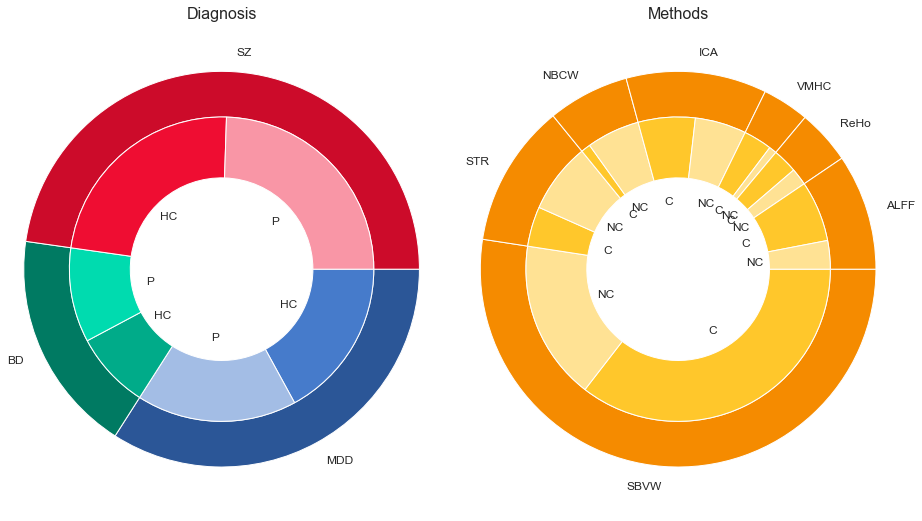

In [63]:
diag_data_perc = pd.DataFrame( columns = diagnosis_data.columns, index = diagnosis_data.index)
diag_data_perc.iloc[0] = diagnosis_data.iloc[0].div(diagnosis_data.iloc[0].sum(),0)*100
diag_data_perc.iloc[1:3,:] = diagnosis_data.iloc[1:3,:].div(diagnosis_data.iloc[1:3,:].sum(axis = 0))*diag_data_perc.iloc[0]
diag_data_perc = diag_data_perc.reindex(columns = diagGroup)

diag_names = diag_data_perc.columns
diag_size= diag_data_perc.iloc[0]
subdiag_names=['HC','P']*len(diag_names)
subdiag_size = pd.melt(diag_data_perc.iloc[1:3])['value']

colors_outer_d = list(diagColors.values())
colors_inner_d = ['#467BCB', '#A3BDE5', '#00AB89', '#00DBAF', '#EF0D32', '#F996A6']

methods_names = methods_data.columns
methods_size= methods_data.iloc[0]
submet_names=['C','NC']*len(methods_names)
submet_size = pd.melt(methods_data.iloc[1:3])['value']

colors_outer_m = ['#F58B00', '#F58B00', '#F58B00', '#F58B00', '#F58B00', '#F58B00']
colors_inner_m = ['#FFC72B', '#FFE294', '#FFC72B', '#FFE294','#FFC72B', '#FFE294','#FFC72B', '#FFE294',
                '#FFC72B', '#FFE294','#FFC72B', '#FFE294']

fig, ax = plt.subplots(1,2,figsize=(15,9));
plot.plot_double_pie(diag_size, subdiag_size, diag_names, subdiag_names, colors_outer_d, colors_inner_d, ax[0])
ax[0].set_title('Diagnosis',fontsize=16)
plot.plot_double_pie(methods_size, submet_size, methods_names, submet_names, colors_outer_m, colors_inner_m, ax[1])
ax[1].set_title('Methods', fontsize=16)


# fig_name= 'donuts.pdf'
# fig.savefig(os.path.join(fig_folder_path,fig_name), format='pdf')

plt.show()

<Figure size 576x1224 with 0 Axes>

<AxesSubplot:xlabel='contrast', ylabel='n_patients'>

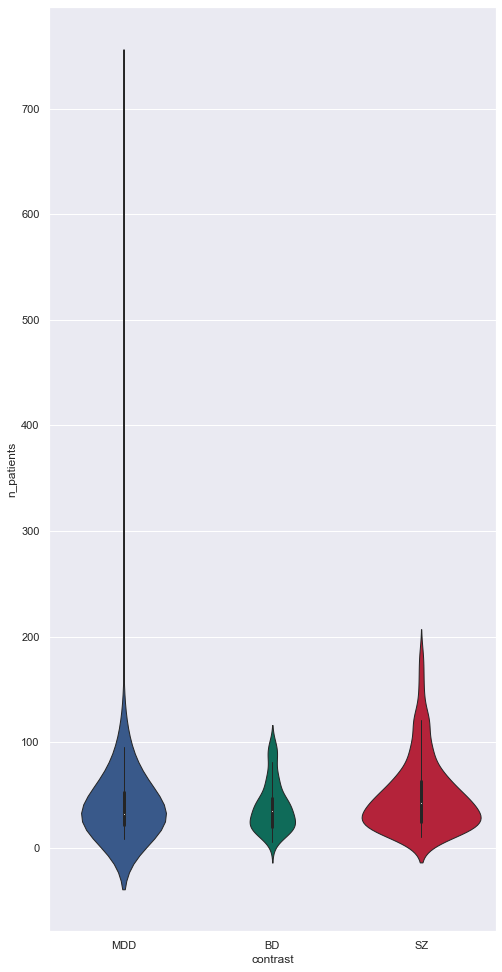

In [64]:
n_patients = pd.concat([n_patients_BD['n_patients'].rename('BD'),n_patients_SZ['n_patients'].rename('SZ'),
                        n_patients_MDD['n_patients'].rename('MDD')], axis=1)

n_patients_groups = pd.melt(n_patients, var_name='contrast', value_name='n_patients').dropna(axis=0)

plt.figure(figsize=(8,17))
sns.violinplot(x='contrast', y='n_patients', data=n_patients_groups, linewidth=1, scale='count', palette= diagColors,
             order=diagGroup)

### Set input data

In [65]:
matrices_dir = os.listdir(input_path)
matrices_path = list(filter(lambda x: 'effects' in x or 'tested' in x, matrices_dir))

#  Data example
results_file_example = pd.read_csv(os.path.join(input_path, matrices_path[0]), index_col=0)
results_file_example

,"Visual1,Visual1","Visual1,Visual2","Visual1,Somatomotor","Visual1,Auditory","Visual1,Language","Visual1,Dorsal-attention","Visual1,Frontoparietal","Visual1,Cingulo-Opercular","Visual1,Default","Visual1,Posterior-Multimodal","Visual1,Ventral-Multimodal","Visual1,Orbito-Affective","Visual2,Visual2","Visual2,Somatomotor","Visual2,Auditory","Visual2,Language","Visual2,Dorsal-attention","Visual2,Frontoparietal","Visual2,Cingulo-Opercular","Visual2,Default","Visual2,Posterior-Multimodal","Visual2,Ventral-Multimodal","Visual2,Orbito-Affective","Somatomotor,Somatomotor","Somatomotor,Auditory","Somatomotor,Language","Somatomotor,Dorsal-attention","Somatomotor,Frontoparietal","Somatomotor,Cingulo-Opercular","Somatomotor,Default","Somatomotor,Posterior-Multimodal","Somatomotor,Ventral-Multimodal","Somatomotor,Orbito-Affective","Auditory,Auditory","Auditory,Language","Auditory,Dorsal-attention","Auditory,Frontoparietal","Auditory,Cingulo-Opercular","Auditory,Default","Auditory,Posterior-Multimodal","Auditory,Ventral-Multimodal","Auditory,Orbito-Affective","Language,Language","Language,Dorsal-attention","Language,Frontoparietal","Language,Cingulo-Opercular","Language,Default","Language,Posterior-Multimodal","Language,Ventral-Multimodal","Language,Orbito-Affective","Dorsal-attention,Dorsal-attention","Dorsal-attention,Frontoparietal","Dorsal-attention,Cingulo-Opercular","Dorsal-attention,Default","Dorsal-attention,Posterior-Multimodal","Dorsal-attention,Ventral-Multimodal","Dorsal-attention,Orbito-Affective","Frontoparietal,Frontoparietal","Frontoparietal,Cingulo-Opercular","Frontoparietal,Default","Frontoparietal,Posterior-Multimodal","Frontoparietal,Ventral-Multimodal","Frontoparietal,Orbito-Affective","Cingulo-Opercular,Cingulo-Opercular","Cingulo-Opercular,Default","Cingulo-Opercular,Posterior-Multimodal","Cingulo-Opercular,Ventral-Multimodal","Cingulo-Opercular,Orbito-Affective","Default,Default","Default,Posterior-Multimodal","Default,Ventral-Multimodal","Default,Orbito-Affective","Posterior-Multimodal,Posterior-Multimodal","Posterior-Multimodal,Ventral-Multimodal","Posterior-Multimodal,Orbito-Affective","Ventral-Multimodal,Ventral-Multimodal","Ventral-Multimodal,Orbito-Affective","Orbito-Affective,Orbito-Affective"
7,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
47,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1701,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1747,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1778,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### Statistic analysis

In [66]:
studies_counts = pd.DataFrame()
nb_studies = pd.DataFrame(index = ['nbr_studies'], columns = diagGroup)

for file_path in matrices_path:
    matrix_file = pd.read_csv(os.path.join(input_path,file_path), index_col=0)
    studies_counts = studies_counts.append(matrix_file.sum(axis = 0),ignore_index=True )
    if 'tested' in file_path:
        group = [dGroup for dGroup in diagGroup if(dGroup in file_path)]
        nb_studies.loc[:,group] = len(matrix_file)

studies_counts.index = matrices_path
for key in atlas_labels.keys():
    studies_counts.columns = studies_counts.columns.str.replace(key, atlas_labels[key])

nb_studies

,MDD,BD,SZ
nbr_studies,159,85,223


In [67]:
studies_countsPercent = pd.DataFrame(columns = studies_counts.columns)
for sub_diagGroup in diagGroup:
    sub_studies_counts = studies_counts.filter(like=sub_diagGroup, axis=0)
    tested = sub_studies_counts.filter(like='tested',axis = 0)
    tested_percent = tested.div(nb_studies.at['nbr_studies',sub_diagGroup])*100
    hypo_percent = sub_studies_counts.filter(like='hypo',axis = 0).div(tested.values)*100
    hyper_percent = sub_studies_counts.filter(like='hyper',axis = 0).div(tested.values)*100
    studies_countsPercent = studies_countsPercent.append([tested_percent,hypo_percent,hyper_percent]).astype(float).round()

studies_counts_index = studies_countsPercent.index
studies_counts = studies_counts.reindex(studies_counts_index)

In [68]:
arrays = [diagGroup, interacType]
multiindex = pd.MultiIndex.from_product(arrays)
studies_number = pd.DataFrame(data = studies_counts.transpose().values, columns=multiindex, index= studies_counts.columns)

studies_number_tested = studies_number.xs('Tested', axis=1, level=1).sum(axis=1).reset_index(name='Tested')
studies_number_tested[['region1', 'region2']] = studies_number_tested['index'].str.split(',', n=1, expand=True)
studies_number_tested = studies_number_tested.drop(columns='index')
studies_number_tested_net = pd.melt(studies_number_tested[['Tested','region1','region2']], id_vars=['Tested'],
                                    value_vars=['region1', 'region2'],
                                    var_name='type', value_name='region').drop(columns='type').drop_duplicates()
studies_number_tested

,Tested,region1,region2
0,184.0,aud,aud
1,166.0,aud,con
2,188.0,aud,dmn
3,69.0,aud,dan
4,208.0,aud,fpn
...,...,...,...
73,82.0,vis2,ora
74,93.0,vis2,pmm
75,82.0,vis2,smn
76,61.0,vis2,vmm


<AxesSubplot:xlabel='region', ylabel='Tested'>

<AxesSubplot:xlabel='region', ylabel='Tested'>

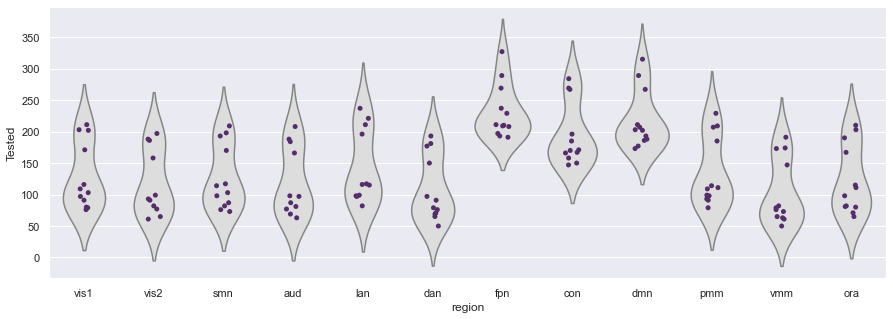

In [69]:
fig= plt.figure(figsize=(15, 5))

sns.violinplot(x='region', y='Tested', data=studies_number_tested_net,
               inner=None, color='#DDDDDD', saturation=1, order=atlas_labels_abb)

sns.stripplot(x='region', y='Tested', data=studies_number_tested_net, color = '#542d6b',
              jitter=True, order=atlas_labels_abb)

In [70]:
studies_percentage = pd.DataFrame(data = studies_countsPercent.transpose().values, columns=multiindex, index= studies_countsPercent.columns)
# csv_name = 'studies_percent.csv'
# studies_percentage.to_csv(os.path.join(fig_folder_path,csv_name), header=True, index=True)

studies_percentage_todisplay = studies_percentage.astype(str).add(' %')
studies_percentage_todisplay

MDD                                   BD                \
           Tested Hypoconnected Hyperconnected  Tested Hypoconnected   
aud,aud    40.0 %         9.0 %          3.0 %  42.0 %         3.0 %   
aud,con    30.0 %         9.0 %          2.0 %  35.0 %        13.0 %   
aud,dmn    41.0 %         9.0 %          8.0 %  41.0 %        23.0 %   
aud,dan    11.0 %         0.0 %          0.0 %  16.0 %         0.0 %   
aud,fpn    38.0 %        10.0 %         15.0 %  47.0 %        15.0 %   
...           ...           ...            ...     ...           ...   
vis2,ora   18.0 %         7.0 %          0.0 %  25.0 %         0.0 %   
vis2,pmm   25.0 %        13.0 %          0.0 %  26.0 %         5.0 %   
vis2,smn   14.0 %        13.0 %          4.0 %  24.0 %         5.0 %   
vis2,vmm   14.0 %         0.0 %          0.0 %  18.0 %         0.0 %   
vis2,vis2  42.0 %        21.0 %          9.0 %  45.0 %        24.0 %   

                              SZ                               
          Hyperconnected  Tested Hypoconnected Hyperconnected  
aud,aud           14.0 %  38.0 %        36.0 %          6.0 %  
aud,con            3.0 %  40.0 %        29.0 %          9.0 %  
aud,dmn            3.0 %  39.0 %        31.0 %         14.0 %  
aud,dan            0.0 %  17.0 %         8.0 %          3.0 %  
aud,fpn            8.0 %  48.0 %        19.0 %         25.0 %  
...                  ...     ...           ...            ...  
vis2,ora           0.0 %  14.0 %         9.0 %          9.0 %  
vis2,pmm           0.0 %  14.0 %         9.0 %          6.0 %  
vis2,smn           0.0 %  17.0 %        33.0 %         15.0 %  
vis2,vmm           0.0 %  11.0 %         0.0 %          8.0 %  
vis2,vis2          5.0 %  37.0 %        37.0 %          8.0 %  

[78 rows x 9 columns]

### Load and create significance table

In [71]:
stats_file_path = list(filter(lambda x: all(item in x for item in stats_methods), matrices_dir))[0]
stats = pd.read_csv(os.path.join(input_path,stats_file_path), index_col= 0, sep=';')
stats.columns = stats.columns.str.replace('.',',')
for key in atlas_labels.keys():
    stats.columns = stats.columns.str.replace(key, atlas_labels[key])

stats_base = stats.loc[list(filter(lambda x: 'diff' not in x, stats.index))]
stats_diff_interact = stats.loc[list(filter(lambda x: 'diffHypoHyper' in x , stats.index))]
stats_diff_groups = stats.drop(stats_diff_interact.index, axis=0).drop(stats_base.index,axis=0)

In [72]:
stats_base.index = pd.MultiIndex.from_tuples(stats_base.index.str.split('_').tolist())
stats_base = stats_base.rename(index = {'hyper':interacType[2],'hypo':interacType[1]})
signif_base = (stats_base<=alpha).astype(int).T
signif_base = signif_base.reindex(studies_countsPercent.columns)
signif_base = signif_base.sort_index(axis=1, level=0)
signif_base_linestyle = (stats_base.applymap(lambda  x: '-')).T
signif_base_linestyle = signif_base_linestyle.reindex(signif_base.index)

# csv_name = 'signif_global.csv'
# signif_base.to_csv(os.path.join(fig_folder_path,csv_name), header=True, index=True)
signif_base

BD                          MDD                \
          Hyperconnected Hypoconnected Hyperconnected Hypoconnected   
aud,aud                0             0              0             0   
aud,con                0             0              0             0   
aud,dmn                0             1              0             0   
aud,dan                0             0              0             0   
aud,fpn                0             0              0             0   
...                  ...           ...            ...           ...   
vis2,ora               0             0              0             0   
vis2,pmm               0             0              0             0   
vis2,smn               0             0              0             0   
vis2,vmm               0             0              0             0   
vis2,vis2              0             1              0             0   

                      SZ                
          Hyperconnected Hypoconnected  
aud,aud                0             1  
aud,con                0             0  
aud,dmn                0             1  
aud,dan                0             0  
aud,fpn                1             0  
...                  ...           ...  
vis2,ora               0             0  
vis2,pmm               0             0  
vis2,smn               0             1  
vis2,vmm               0             0  
vis2,vis2              0             1  

[78 rows x 6 columns]

In [73]:
stats_diff_interact.index = stats_diff_interact.index.str.replace('_diffHypoHyper','')
signif_diff_interact = (stats_diff_interact<=alpha).astype(int).T
signif_diff_interact = signif_diff_interact.reindex(studies_countsPercent.columns)
signif_diff_interact = signif_diff_interact.sort_index(axis=1)

signif_diff_interact_linestyle = (stats_diff_interact.applymap(lambda  x: '-')).T
signif_diff_interact_linestyle = signif_diff_interact_linestyle.reindex(signif_diff_interact.index)

# csv_name = 'signif_diff_interact.csv'
# signif_diff_interact.to_csv(os.path.join(fig_folder_path,csv_name), header=True, index=True)

In [74]:
stats_diff_groups.index = pd.MultiIndex.from_tuples(stats_diff_groups.index.str.split('_diffGroup_').tolist())
stats_diff_groups = stats_diff_groups.rename(index = {'hyper':interacType[2],'hypo':interacType[1]})
signif_diff_groups = (stats_diff_groups<=alpha).astype(int).T
signif_diff_groups = signif_diff_groups.reindex(studies_countsPercent.columns)
signif_diff_groups = signif_diff_groups.sort_index(axis=1, level=0)

signif_diff_groups_linestyle = (stats_diff_groups.applymap(lambda x: '-')).T
signif_diff_groups_linestyle = signif_diff_groups_linestyle.reindex(signif_diff_groups.index)

# csv_name = 'signif_diff_groups.csv'
# signif_diff_groups.to_csv(os.path.join(fig_folder_path,csv_name), header=True, index=True)

### Data Regression analysis for each group

Text(0.5, 0, 'Hypoconnected')

Text(0.5, 0, 'Hyperconnected')

Text(0.5, 0, 'Tested')

(0.0, 80.0)

(0.0, 80.0)

(0.0, 80.0)

Text(0.5, 0.92, 'MDD')

Text(0.5, 0, 'Hypoconnected')

Text(0.5, 0, 'Hyperconnected')

Text(0.5, 0, 'Tested')

(0.0, 80.0)

(0.0, 80.0)

(0.0, 80.0)

Text(0.5, 0.92, 'BD')

Text(0.5, 0, 'Hypoconnected')

Text(0.5, 0, 'Hyperconnected')

Text(0.5, 0, 'Tested')

(0.0, 80.0)

(0.0, 80.0)

(0.0, 80.0)

Text(0.5, 0.92, 'SZ')

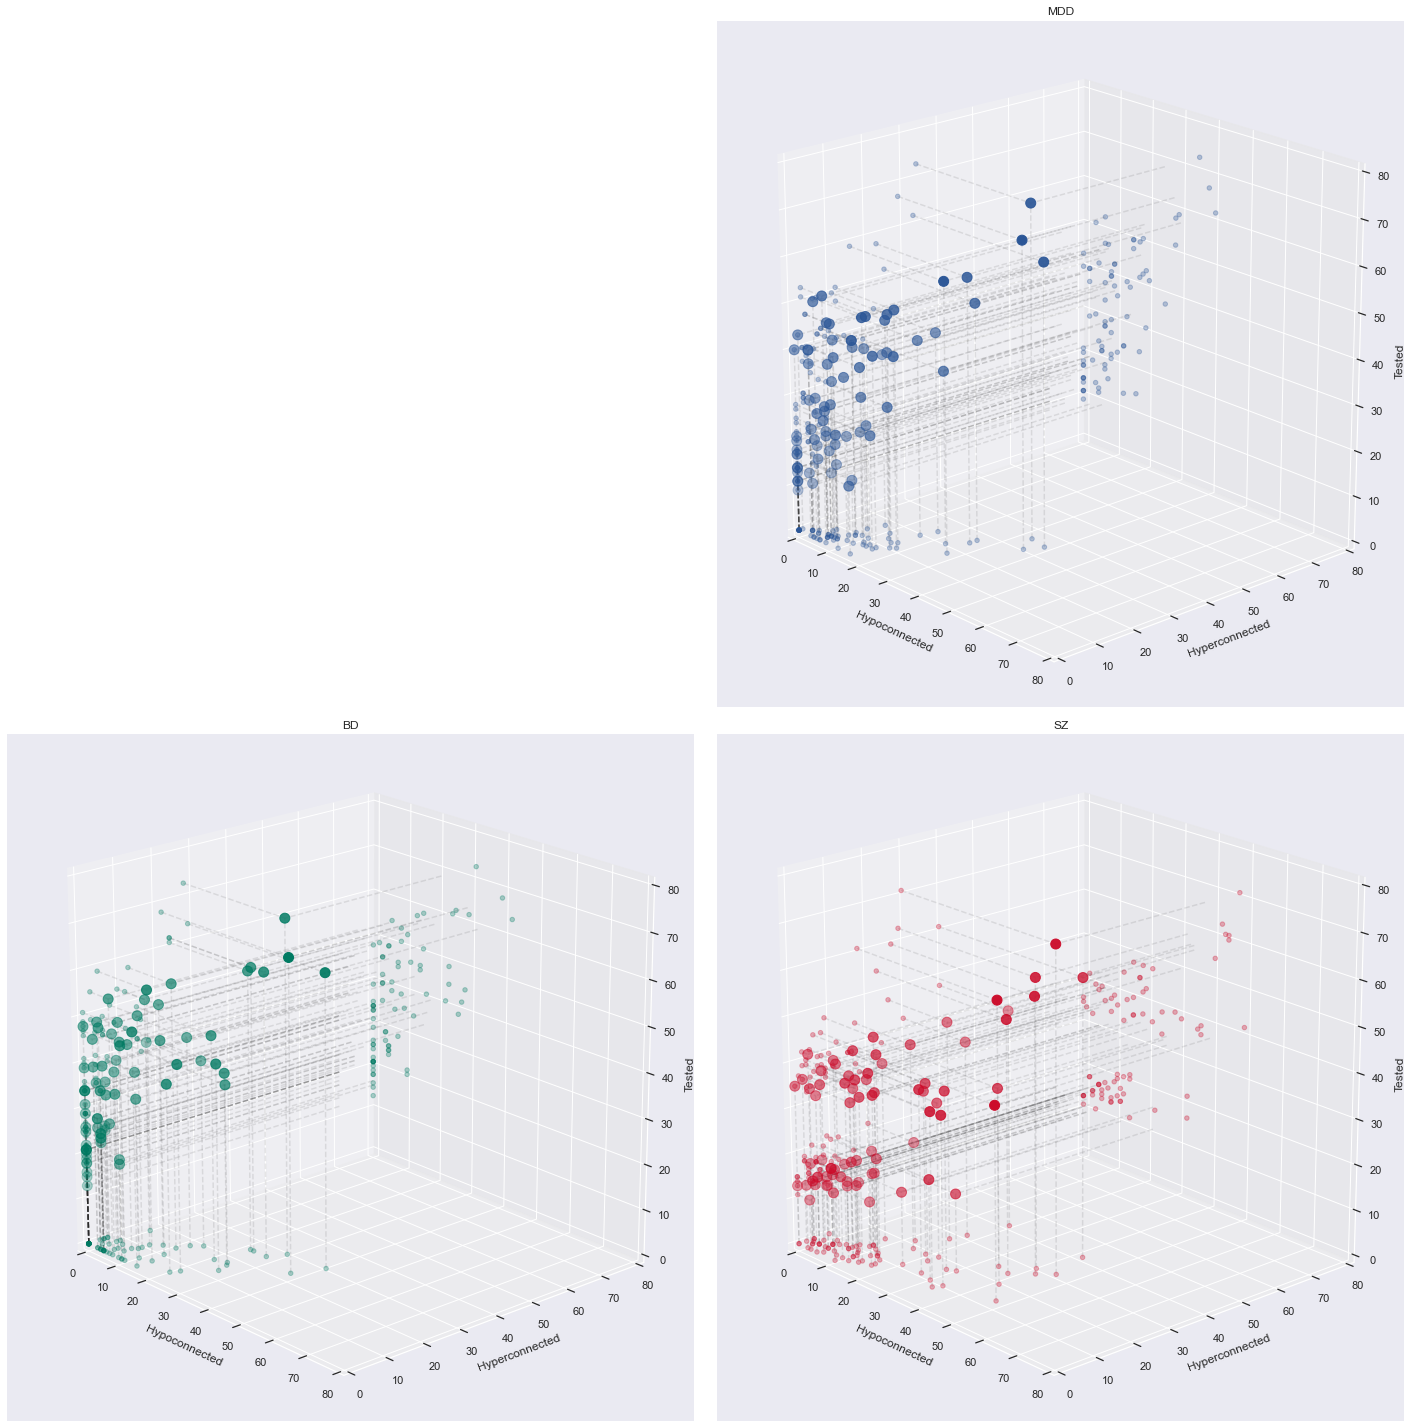

In [75]:
max_axis = int(math.ceil(studies_percentage.max().max()/ 10.0)) * 10
num_rows = len(diagGroup)
num_cols = len(interacType)

fig = plt.figure(figsize = (20,20))
N = len(studies_percentage)

for i, group in enumerate(diagGroup):

    x = studies_percentage[group][interacType[1]].values
    y = studies_percentage[group][interacType[2]].values
    z = studies_percentage[group][interacType[0]].values

    ax3d = fig.add_subplot(2, 2, i+2, projection='3d');
    ax3d.set_box_aspect((1, 1, 1))
    ax3d.set_xlabel(interacType[1]);
    ax3d.set_ylabel(interacType[2]);
    ax3d.set_zlabel(interacType[0]);
    ax3d.set_xlim([0, max_axis]);
    ax3d.set_ylim([0, max_axis]);
    ax3d.set_zlim([0, max_axis]);
    ax3d.set_title(diagGroup[i])
    plot.plot_scatter3D(x, y, z, N, colors=diagColors[group], markers = 'o', ax3d= ax3d)

fig.tight_layout()

# fig_name= '3D_plots_diagGroups.pdf'
# fig.savefig(os.path.join(fig_folder_path,fig_name), format='pdf')

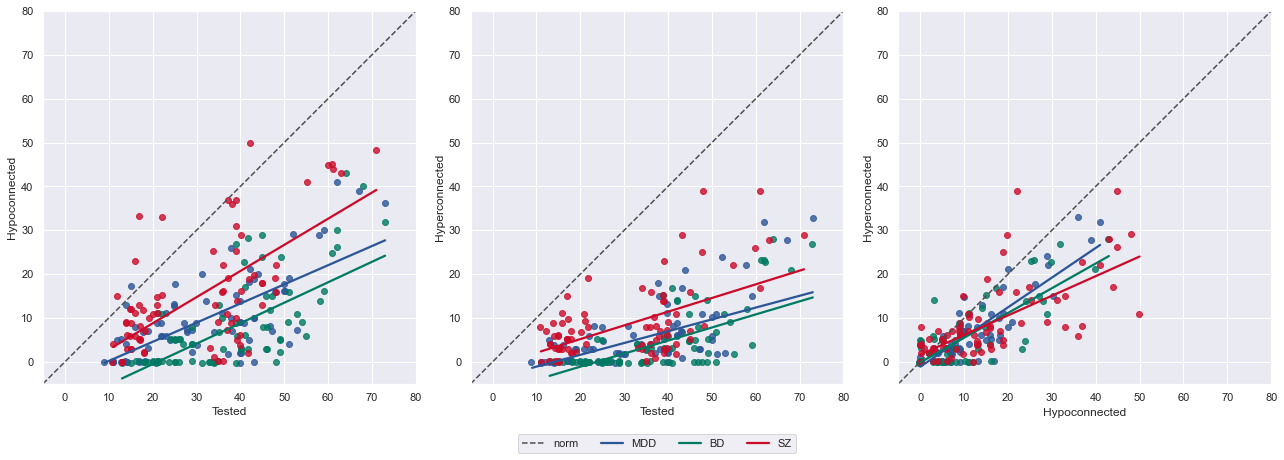

In [76]:
effect_perm = list(combinations(interacType,2))
fig, axs = plt.subplots(1,len(effect_perm),figsize = (18,10))

for i,cont in enumerate(effect_perm):
    X_type = cont[0]
    Y_type = cont[1]
    plot.plot_reg_analysis(studies_percentage, diagGroup, X_type ,Y_type, diagColors, ax=axs[i])

axs.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), labels=['norm']+diagGroup, ncol=4)
fig.tight_layout()

# fig_name= '2D_regplots_diagGroups.pdf'
# fig.savefig(os.path.join(fig_folder_path,fig_name), format='pdf')

Text(0, 15, 'MDD')

Text(0, 15, 'BD')

Text(0, 15, 'SZ')

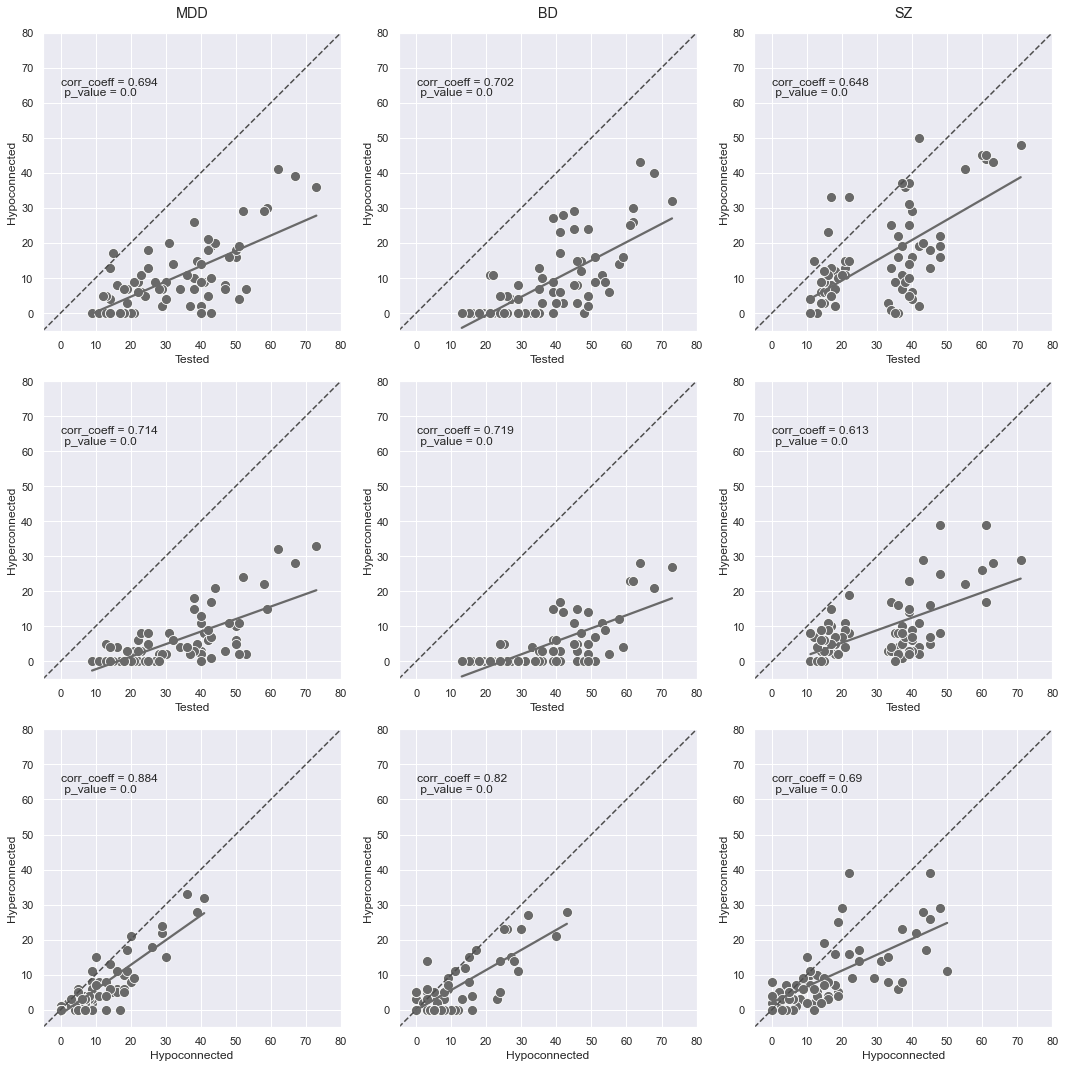

In [77]:
fig, axs = plt.subplots(num_rows, num_cols, figsize = (15,15))
pad = 15

for i in range(len(diagGroup)):
    X_diagGroup = diagGroup[i]
    Y_diagGroup = X_diagGroup
    for j,sub_type in enumerate(effect_perm):
        X_type = sub_type[0]
        Y_type = sub_type[1]
        plot.plot_corr_analysis(studies_percentage, X_diagGroup, X_type, Y_diagGroup, Y_type, ax=axs[j][i])

for ax, col in zip(axs[0], diagGroup):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline');

fig.tight_layout()

# fig_name= '2D_regplots_diagGroups_2.pdf'
# fig.savefig(os.path.join(fig_folder_path,fig_name), format='pdf')

Text(0.5, 0, 'MDD')

Text(0.5, 0, 'BD')

Text(0.5, 0, 'SZ')

(0.0, 80.0)

(0.0, 80.0)

(0.0, 80.0)

Text(0.5, 0.92, 'Tested')

Text(0.5, 0, 'MDD')

Text(0.5, 0, 'BD')

Text(0.5, 0, 'SZ')

(0.0, 80.0)

(0.0, 80.0)

(0.0, 80.0)

Text(0.5, 0.92, 'Hypoconnected')

Text(0.5, 0, 'MDD')

Text(0.5, 0, 'BD')

Text(0.5, 0, 'SZ')

(0.0, 80.0)

(0.0, 80.0)

(0.0, 80.0)

Text(0.5, 0.92, 'Hyperconnected')

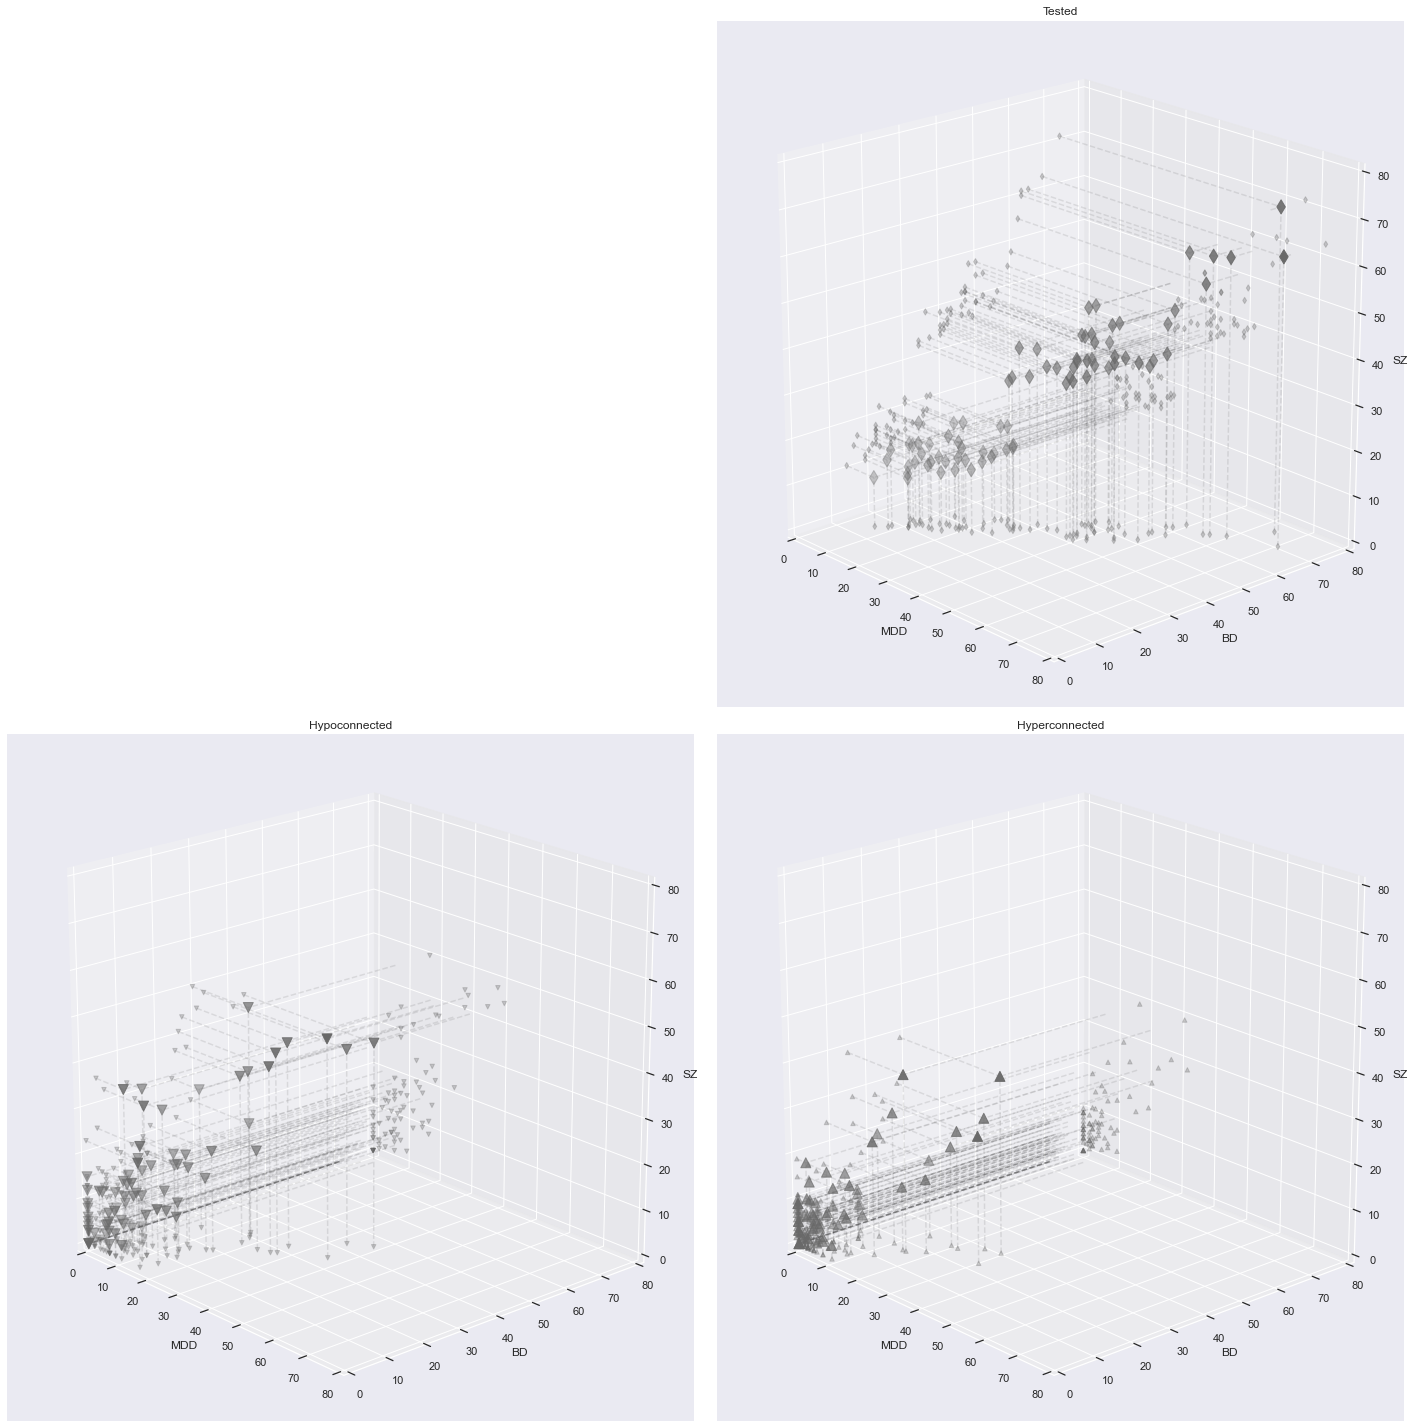

In [78]:
#max_axis = int(math.ceil(studies_percentage.xs(key=effect, axis=1, level=1).max().max()/ 10.0))*10

fig = plt.figure(figsize = (20,20))

for i, effect in enumerate(interacType):
    x = studies_percentage[diagGroup[0]][effect].values
    y = studies_percentage[diagGroup[1]][effect].values
    z = studies_percentage[diagGroup[2]][effect].values

    ax3d = fig.add_subplot(2, 2, i+2, projection='3d');
    ax3d.set_box_aspect((1, 1, 1));
    ax3d.set_xlabel(diagGroup[0]);
    ax3d.set_ylabel(diagGroup[1]);
    ax3d.set_zlabel(diagGroup[2]);
    ax3d.set_xlim([0, max_axis]);
    ax3d.set_ylim([0, max_axis]);
    ax3d.set_zlim([0, max_axis]);
    ax3d.set_title(interacType[i])
    plot.plot_scatter3D(x, y, z, N, colors='dimgray', markers= typeMarkers[effect], ax3d=ax3d)

fig.tight_layout()

# fig_name= '3D_plots_interactions.pdf'
# fig.savefig(os.path.join(fig_folder_path,fig_name), format='pdf')

Text(0, 15, "('MDD', 'BD')")

Text(0, 15, "('MDD', 'SZ')")

Text(0, 15, "('BD', 'SZ')")

Text(-19.0, 0, 'Tested')

Text(-19.0, 0, 'Hypoconnected')

Text(-19.0, 0, 'Hyperconnected')

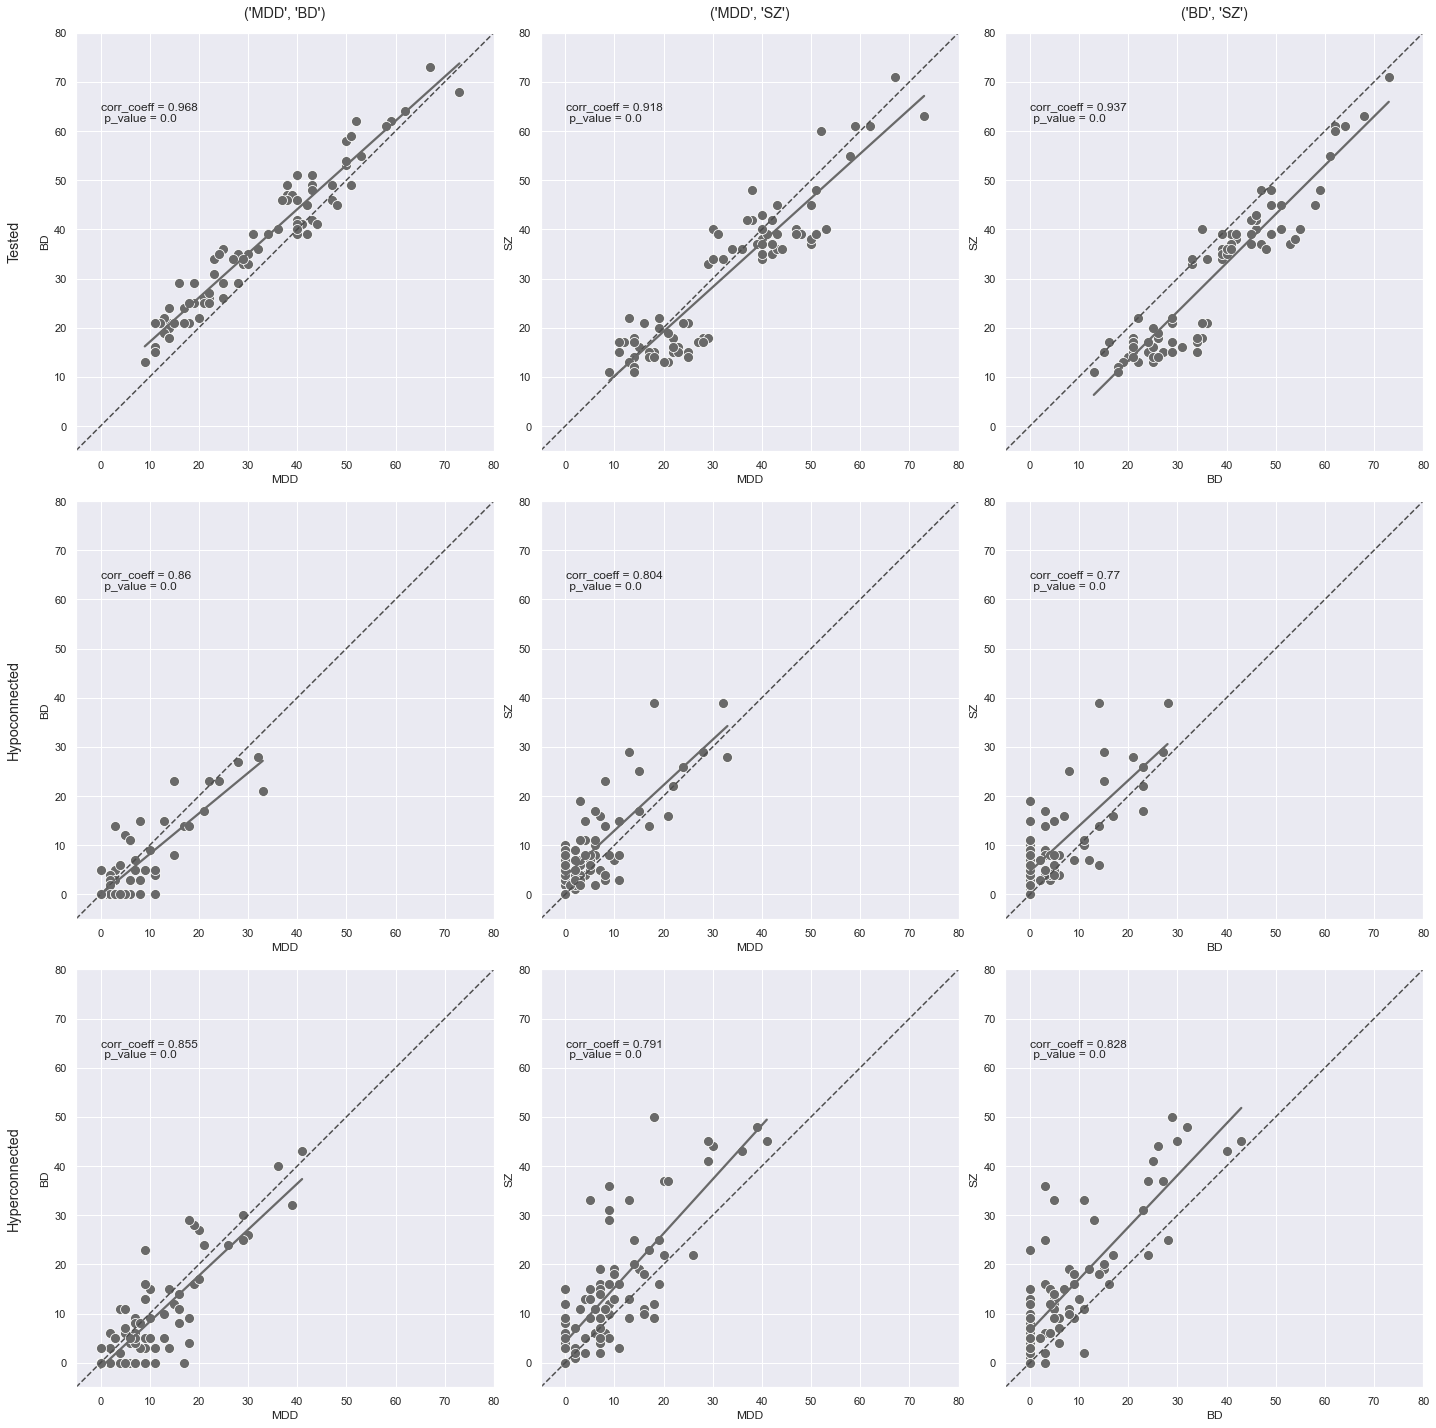

In [79]:
fig, axs = plt.subplots(num_rows, num_cols, figsize = (20,20))

diag_perm = list(combinations(diagGroup,2))

cols = diag_perm
rows = interacType
pad = 15

for i,cont in enumerate(diag_perm):
    X_diagGroup = cont[0]
    Y_diagGroup = cont[1]

    X_type = 'Tested'
    Y_type = X_type
    plot.plot_corr_analysis(studies_percentage ,X_diagGroup,X_type,Y_diagGroup,Y_type, ax=axs[0][i])

    X_type = 'Hyperconnected'
    Y_type = X_type
    plot.plot_corr_analysis(studies_percentage, X_diagGroup,X_type,Y_diagGroup,Y_type, ax=axs[1][i])

    X_type = 'Hypoconnected'
    Y_type = X_type
    plot.plot_corr_analysis(studies_percentage, X_diagGroup,X_type,Y_diagGroup,Y_type, ax=axs[2][i])

for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline');

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center',rotation=90);

fig.tight_layout()

# fig_name= '2D_regplots_interactions.pdf'
# fig.savefig(os.path.join(fig_folder_path,fig_name), format='pdf')

### Data vizualisation with heatmaps

[None, None]

[None, None]

[None, None]

[None, None]

[None, None]

[None, None]

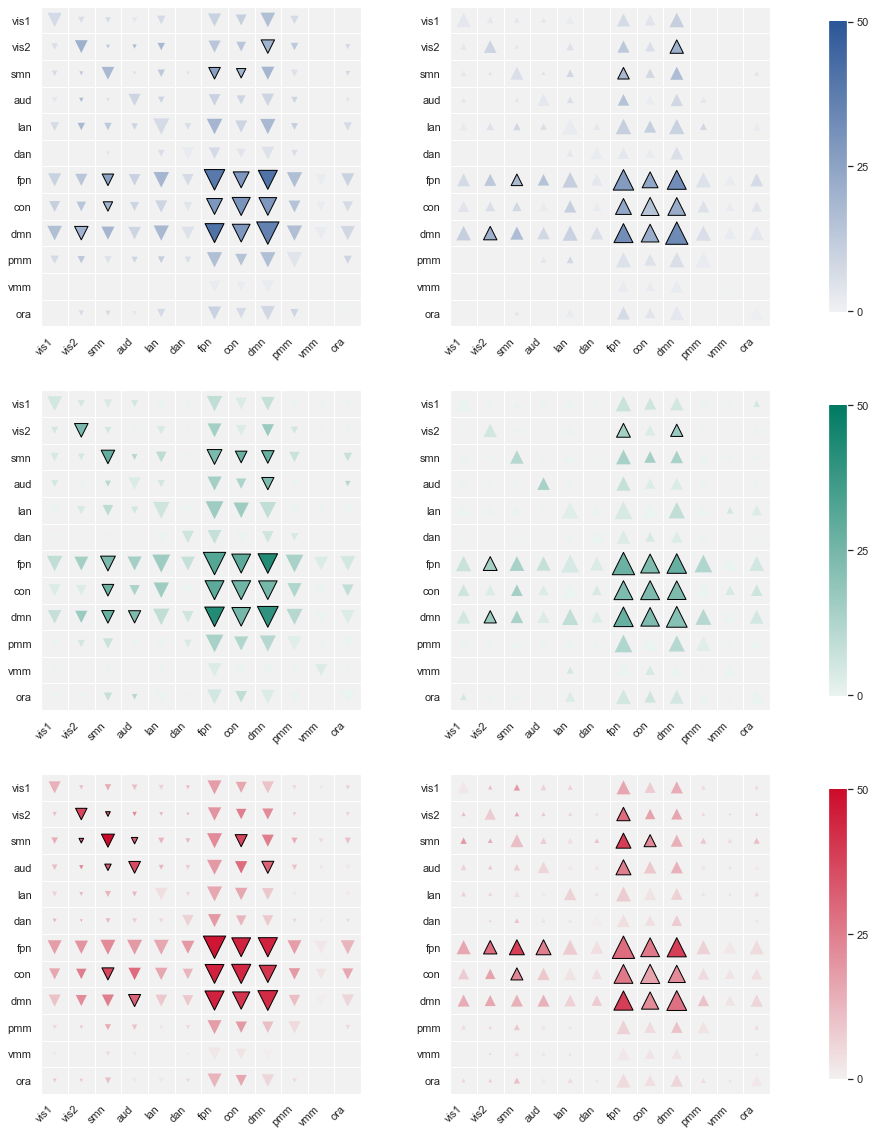

In [80]:
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15,20), gridspec_kw={'width_ratios': [20, 20, 1],
                                                                                      'wspace': 0.1, 'hspace':0.2} )

max_axis = int(math.ceil(studies_percentage.loc[:,
                         (slice(None), [interacType[1],interacType[2]])].max().max()/ 10.0)) * 10

n_color = 256
color_min = 0
color_max = max_axis

for i in range(num_rows):
    group = diagGroup[i]
    cmap = sns.light_palette(diagColors[group], n_colors=n_color)

    for j in range(num_cols-1):
        effect = interacType[j+1]
        data = studies_percentage[group][['Tested',effect]].reset_index()
        data['linewidths'] = signif_base[group][effect].reset_index(drop=True)
        data['linestyle'] = signif_base_linestyle[group][effect].reset_index(drop=True)
        data[['region1','region2']] = data['index'].str.split(",",expand = True)
        dataCol_order = data.columns.to_list()
        dataCol_order[-1] , dataCol_order[-2] = dataCol_order[-2] , dataCol_order[-1]
        data_inverted = data.reindex(columns= dataCol_order).rename(columns = dict(zip(dataCol_order, data.columns.to_list())))
        data = pd.concat([data, data_inverted], ignore_index=True).drop_duplicates()
        axs[i,j].set(adjustable='box', aspect='equal')
        marker = typeMarkers[effect]
        plot.heatmap(x = data['region1'],
                y = data['region2'],
                ax = axs[i,j],
                linewidths = data['linewidths'],
                linestyle= data['linestyle'],
                size = data['Tested'].apply(np.square),
                color = data[effect],
                marker = marker,
                color_range = [color_min,color_max],
                #size_range = [color_min,color_max],
                palette = cmap,
                x_order=atlas_labels_abb,
                y_order=np.flip(atlas_labels_abb))

    axs[i,2] = plot.colorbar(cmap, n_color, color_min, color_max, ax= axs[i,2])

# fig_name= 'heatmarkers_global.pdf'
# fig.savefig(os.path.join(fig_folder_path,fig_name), format='pdf')

In [81]:
data = studies_percentage['BD'][['Tested',effect]].reset_index()
data['linewidth'] = signif_base['BD'][effect].reset_index(drop=True)

### Visualization with multiples comparisons between interactions hypo/hyper

In [82]:
## Data
studies_perc_diff_interac = studies_percentage.copy()
for group in studies_percentage.columns.get_level_values(0):
    studies_perc_diff_interac[group,'hyperhypo_diff'] = studies_perc_diff_interac[group,'Hyperconnected']-studies_perc_diff_interac[group,'Hypoconnected']

studies_perc_diff_interac = studies_perc_diff_interac.drop(columns=[interacType[1],interacType[2]], level=1)

# csv_name = 'studies_perc_diff_interac.csv'
# studies_perc_diff_interac.to_csv(os.path.join(fig_folder_path,csv_name), header=True, index=True)

[None, None]

[None, None]

[None, None]

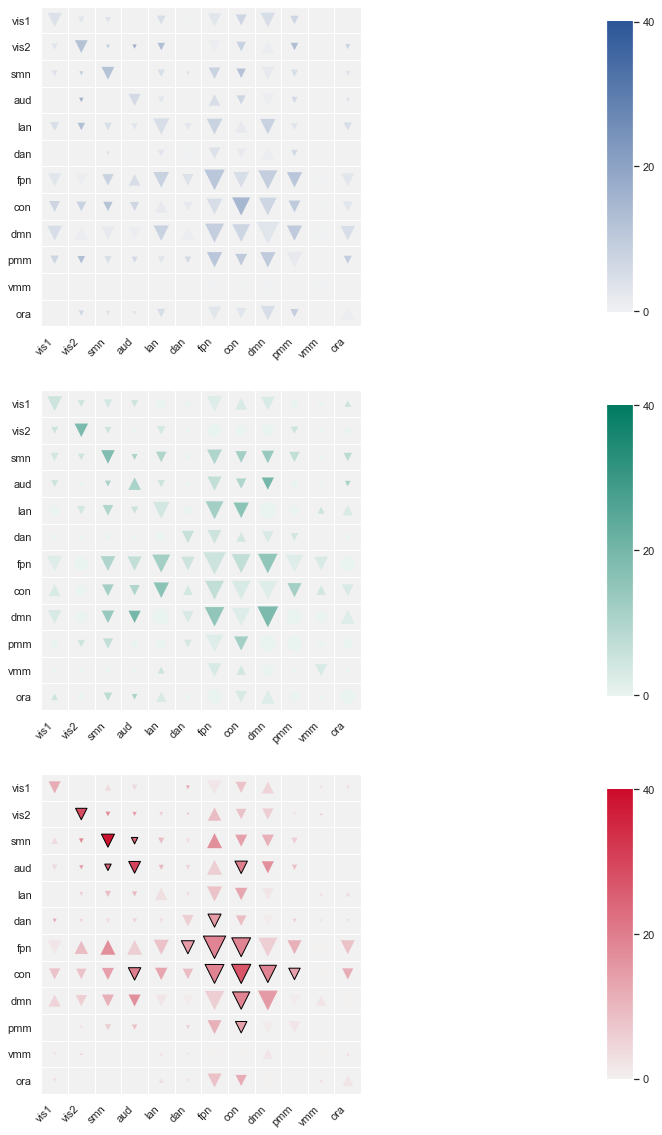

In [83]:
max_axis = int(math.ceil(studies_perc_diff_interac.xs(key='hyperhypo_diff', axis=1, level=1).apply(np.abs).max().max()/ 10.0)) * 10

color_min = 0
color_max = max_axis

fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(15,20), gridspec_kw={'width_ratios': [30, 1],
                                                                                      'wspace': 0, 'hspace':0.2} )

for i in range(num_rows):
    group = diagGroup[i]
    cmap = sns.light_palette(diagColors[group], n_colors=n_color)

    data = studies_perc_diff_interac[group].reset_index()
    data['linewidths'] = signif_diff_interact[group].reset_index(drop=True)
    data['linestyle'] = signif_diff_interact_linestyle[group].reset_index(drop=True)
    data[['region1','region2']] = data['index'].str.split(",",expand = True)
    dataCol_order = data.columns.to_list()
    dataCol_order[-1] , dataCol_order[-2] = dataCol_order[-2] , dataCol_order[-1]
    data_inverted = data.reindex(columns= dataCol_order).rename(columns = dict(zip(dataCol_order, data.columns.to_list())))
    data = pd.concat([data, data_inverted], ignore_index=True).drop_duplicates()
    axs[i,0].set(adjustable='box', aspect='equal')
    marker = data.apply(lambda row: (row.hyperhypo_diff>0)*typeMarkers['Hyperconnected'] +
                                    (row.hyperhypo_diff<0)*typeMarkers['Hypoconnected'] +
                                    (row.hyperhypo_diff==0)*'o', axis=1)

    plot.heatmap(x = data['region1'],
            y = data['region2'],
            ax = axs[i,0],
            linewidths = data['linewidths'],
            linestyle= data['linestyle'],
            size = data['Tested'].apply(np.square),
            color = data['hyperhypo_diff'].apply(np.abs),
            marker = marker,
            color_range = [color_min,color_max],
            #size_range = [color_min,color_max],
            palette = cmap,
            x_order=atlas_labels_abb,
            y_order=np.flip(atlas_labels_abb))

    axs[i,1] = plot.colorbar(cmap, n_color, color_min, color_max, ax= axs[i,1])

# fig_name= 'heatmarkers_diffHypoHyper.pdf'
# fig.savefig(os.path.join(fig_folder_path,fig_name), format='pdf')

### Visualization with multiples comparisons between groups

In [84]:
## Data
studies_perc_diff_effects = studies_percentage.copy()

for group_perm in diag_perm:
    columns_name = group_perm[0] +'_'+ group_perm[1]
    studies_perc_diff_effects[columns_name, interacType[0]] = (studies_perc_diff_effects[group_perm[0],interacType[0]] +
                                                               studies_perc_diff_effects[group_perm[1],interacType[0]])/2

    studies_perc_diff_effects[columns_name, interacType[1]] = (studies_perc_diff_effects[group_perm[0],interacType[1]] -
                                                               studies_perc_diff_effects[group_perm[1],interacType[1]])

    studies_perc_diff_effects[columns_name, interacType[2]] = (studies_perc_diff_effects[group_perm[0],interacType[2]] -
                                                               studies_perc_diff_effects[group_perm[1],interacType[2]])

studies_perc_diff_effects = studies_perc_diff_effects.drop(studies_percentage.columns, axis=1)
group_comparison = studies_perc_diff_effects.columns.get_level_values(0).unique()

# csv_name = 'studies_perc_diff_effects.csv'
# studies_perc_diff_effects.to_csv(os.path.join(fig_folder_path,csv_name), header=True, index=True)

[None, None]

[None, None]

[None, None]

[None, None]

[None, None]

[None, None]

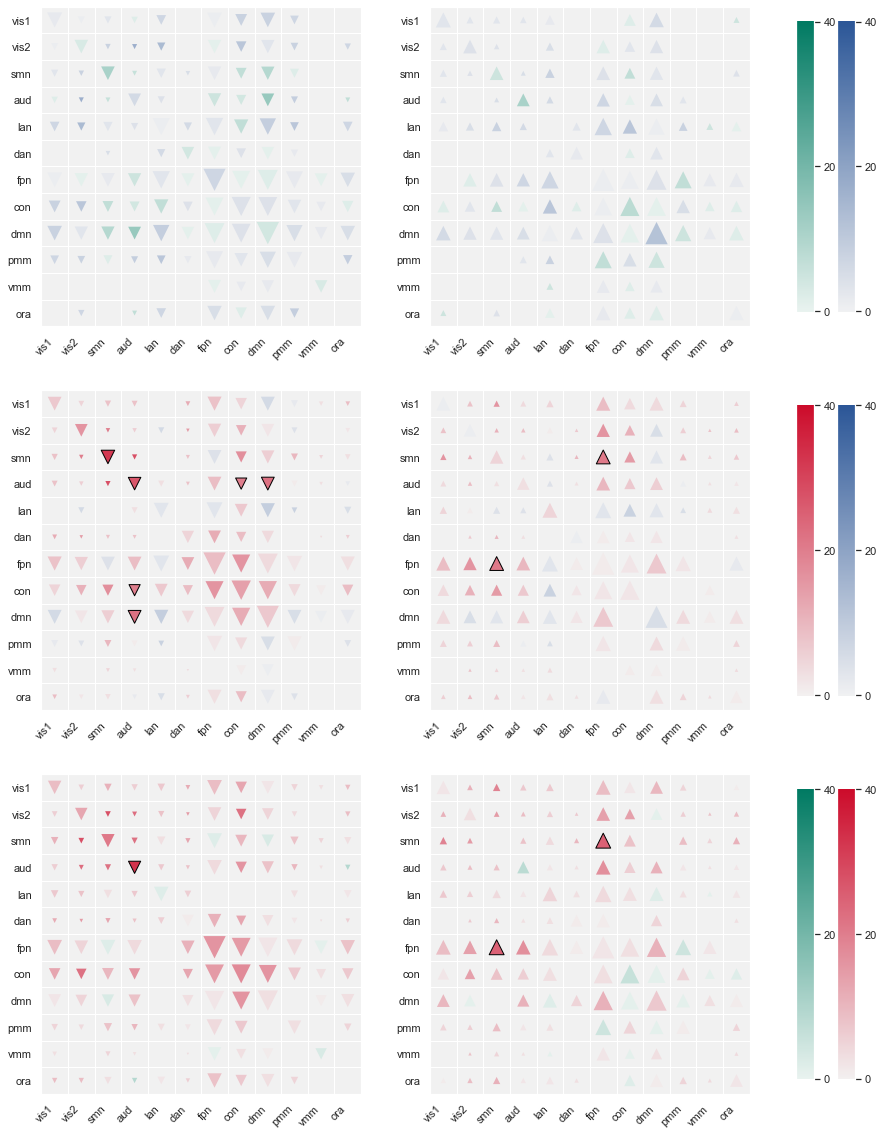

In [85]:
max_axis = int(math.ceil(studies_perc_diff_effects.loc[:,
                         (slice(None), [interacType[1],interacType[2]])].apply(np.abs).max().max()/ 10.0)) * 10

n_color = 256
color_min = 0
color_max = max_axis

fig, axs = plt.subplots(nrows=len(diag_perm), ncols=studies_perc_diff_effects.columns.nlevels+2, figsize=(15,20),
                        gridspec_kw={'width_ratios': [20,20,1,1], 'wspace': 0.12, 'hspace':0.2} )

for i in range(num_rows):

    group = group_comparison[i]
    group1, group2 = diag_perm[i]

    for j in range(num_cols-1):

        effect = interacType[j+1]
        data = studies_perc_diff_effects[group][['Tested',effect]].reset_index()
        data['linewidths'] = signif_diff_groups[group][effect].reset_index(drop=True)
        data['linestyle'] = signif_diff_groups_linestyle[group][effect].reset_index(drop=True)
        data[['region1','region2']] = data['index'].str.split(",",expand = True)
        dataCol_order = data.columns.to_list()
        dataCol_order[-1] , dataCol_order[-2] = dataCol_order[-2] , dataCol_order[-1]
        data_inverted = data.reindex(columns= dataCol_order).rename(columns = dict(zip(dataCol_order, data.columns.to_list())))
        data = pd.concat([data, data_inverted], ignore_index=True).drop_duplicates()
        palette_list = data.apply(lambda row: (row[effect] > 0)*diagColors[group1] +
                                        (row[effect] < 0)*diagColors[group2] +
                                        (row[effect] == 0)*'white', axis=1)
        axs[i,j].set(adjustable='box', aspect='equal')

        plot.heatmap(x = data['region1'],
                y = data['region2'],
                ax = axs[i,j],
                linewidths = data['linewidths'],
                linestyle = data['linestyle'],
                size = data['Tested'].apply(np.square),
                color = data[effect].apply(np.abs),
                marker = typeMarkers[effect],
                color_range = [color_min,color_max],
                palette_list = palette_list,
                x_order=atlas_labels_abb,
                y_order=np.flip(atlas_labels_abb))

    cmap = sns.light_palette(palette_list.unique()[0], n_color)
    axs[i,2] = plot.colorbar(cmap, n_color, color_min, color_max, ax= axs[i,2])

    cmap = sns.light_palette(palette_list.unique()[1], n_color)
    axs[i,3] = plot.colorbar(cmap, n_color, color_min, color_max, ax= axs[i,3])

# fig_name= 'heatmarkers_diffGroups.pdf'
# fig.savefig(os.path.join(fig_folder_path,fig_name), format='pdf')

### Results recap

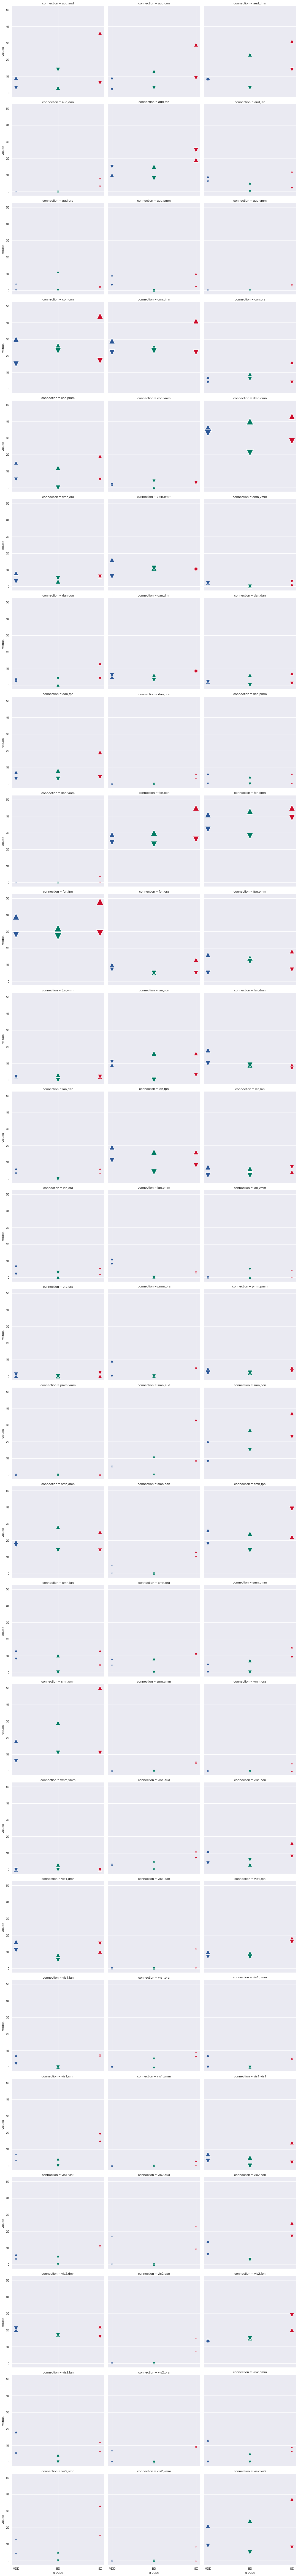

In [86]:
studies_perc_melt = studies_percentage.loc[:, (slice(None), [interacType[1],interacType[2]])].unstack().reset_index()
studies_perc_melt.columns = ['groups', 'interaction', 'connection', 'values']

size_df = studies_percentage.xs('Tested',level=1, axis=1).unstack().reset_index()
size_df.columns = ['groups', 'connection', 'values_size']
studies_perc_melt_data = pd.merge(studies_perc_melt, size_df, on= ['groups','connection'])

fig = sns.relplot(x = 'groups', y= 'values', data= studies_perc_melt_data, style='interaction',hue='groups',
            size=studies_perc_melt_data['values_size'].apply(np.square),
            col= 'connection', col_wrap=3, kind= 'scatter', markers=['^','v'], sizes=(30,700), palette= diagColors,
            legend = False)

# fig_name= 'scatters_network-wise.pdf'
# fig.savefig(os.path.join(fig_folder_path,fig_name), format='pdf')

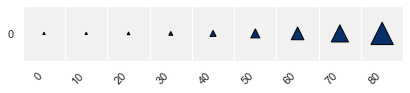

In [87]:
tested = studies_percentage.xs('Tested',level=1, axis=1)
tested_max = int(math.ceil(tested.max().max()/10)+1)*10
tested_min = int(math.floor(tested.min().min()/10))*10
tested_range = np.arange(tested_min,tested_max, 10)
tested_size_range = list(map(lambda x:x**2,tested_range))
tested_data = pd.DataFrame(data= zip(tested_range,tested_size_range), columns = ['value','size'])

fig,axs = plt.subplots(1,2,figsize=(15,1))
fig.delaxes(axs[1])
plot.heatmap(x = tested_data['value'],
             y =[0]*len(tested_data['value']),
             ax = axs[0],
             size = tested_data['size'].apply(np.square),
             marker = '^',
             linestyle ='-',
             )

### Heteromodal networks analysis

In [88]:
pd.set_option('display.max_columns', 2000)
matrices_folder_path = r'../results/aal3_bilateral_input_cole12_n428_max'
input_path = os.path.abspath(matrices_folder_path)
cur_dir = os.listdir(input_path)
matrices_path = list(filter(lambda x: 'effects' in x or 'tested' in x, cur_dir))

studies_counts = pd.DataFrame()
nb_studies = pd.DataFrame(index = ['nbr_studies'], columns = diagGroup)

for file_path in matrices_path:
    matrix_file = pd.read_csv(os.path.join(input_path,file_path), index_col=0)
    studies_counts = studies_counts.append(matrix_file.sum(axis = 0),ignore_index=True )
    if 'tested' in file_path:
        group = [dGroup for dGroup in diagGroup if(dGroup in file_path)]
        nb_studies.loc[:,group] = len(matrix_file)

studies_counts.index = matrices_path
for key in atlas_labels.keys():
    studies_counts.columns = studies_counts.columns.str.replace(key, atlas_labels[key])

studies_countsPercent = pd.DataFrame(columns = studies_counts.columns)
for sub_diagGroup in diagGroup:
    sub_studies_counts = studies_counts.filter(like=sub_diagGroup, axis=0)
    tested = sub_studies_counts.filter(like='tested',axis = 0)
    tested_percent = tested.div(nb_studies.at['nbr_studies',sub_diagGroup])*100
    hyper_percent = sub_studies_counts.filter(like='hyper',axis = 0).div(tested.values)*100
    hypo_percent = sub_studies_counts.filter(like='hypo',axis = 0).div(tested.values)*100
    studies_countsPercent = studies_countsPercent.append([tested_percent,hyper_percent,hypo_percent]).astype(float).round()

studies_counts_index = studies_countsPercent.index
studies_counts = studies_counts.reindex(studies_counts_index)

studies_percentage = pd.DataFrame(data = studies_countsPercent.transpose().values, columns=multiindex, index= studies_countsPercent.columns)


studies_perc_diff_group = studies_percentage.copy()

for group_perm in diag_perm:
    columns_name = group_perm[0] +'_'+ group_perm[1]

    studies_perc_diff_group[columns_name, interacType[1]] = (studies_perc_diff_group[group_perm[0],interacType[1]] -
                                                               studies_perc_diff_group[group_perm[1],interacType[1]])

    studies_perc_diff_group[columns_name, interacType[2]] = (studies_perc_diff_group[group_perm[0],interacType[2]] -
                                                               studies_perc_diff_group[group_perm[1],interacType[2]])

studies_perc_diff_group = studies_perc_diff_group.drop(studies_percentage.columns, axis=1)

studies_number_max = studies_perc_diff_group.abs().max(axis=1)
studies_number_idxmax = studies_perc_diff_group.abs().idxmax(axis=1)

studies_number_max_df = pd.DataFrame(studies_number_max, columns=['max'], index=studies_number_max.index)
studies_number_max_df['to_drop'], studies_number_max_df['interacType'] = zip(*studies_number_idxmax)
studies_number_max_df = studies_number_max_df.drop(columns='to_drop')
studies_number_max_df.sort_values(by='max', ascending=False)


,max,interacType
"Insula,Putamen",34.0,Hyperconnected
"Cerebellum_Crus2,Thalamus",26.0,Hyperconnected
"Temporal_Mid,Thalamus",26.0,Hypoconnected
"Cerebellum_9,Thalamus",25.0,Hyperconnected
"Frontal_Mid_2,Thalamus",24.0,Hyperconnected
...,...,...
"Frontal_Med_Orb,Raphe_M",0.0,Hypoconnected
"Frontal_Med_Orb,Red_N",0.0,Hypoconnected
"Frontal_Med_Orb,SN_pc",0.0,Hypoconnected
"Frontal_Med_Orb,SN_pr",0.0,Hypoconnected


In [89]:
networks_CAB_NP = pd.read_csv('../input/conversion_CAB-NP_DMN-CON-FPN_aal3.csv', header=0)
networks_aal3_combination = [','.join(i) for i in list(itertools.combinations_with_replacement(networks_CAB_NP.aal3, 2))]
networks_CAB_NP_combination = list(map(lambda x: ','.join(sorted(x)),
                                       list(itertools.combinations_with_replacement(networks_CAB_NP['CAB-NP'], 2))))

networks_combinations = pd.DataFrame(networks_CAB_NP_combination, index=networks_aal3_combination,
                                     columns=['CAB-NP'])
networks_combinations = pd.concat([networks_combinations, studies_number_max_df], axis=1)

networks_combinations_grouped = networks_combinations[['CAB-NP','max']].groupby('CAB-NP')
connexion_df = pd.DataFrame(columns=['aal3','CAB-NP'])
for name, group in networks_combinations_grouped:
    group_tested = group['max']
    group_connexions = pd.DataFrame([group_tested.nlargest(3).index, [name]*3], index=['aal3','CAB-NP']).transpose()
    connexion_df = pd.concat([connexion_df, group_connexions])
connexion_df


,aal3,CAB-NP
0,"Insula,Putamen","con,con"
1,"Supp_Motor_Area,Putamen","con,con"
2,"Cingulate_Mid,Putamen","con,con"
0,"Insula,Temporal_Mid","con,dmn"
1,"Frontal_Sup_Medial,ACC_sup","con,dmn"
2,"Cingulate_Mid,Cingulate_Post","con,dmn"
0,"Cerebellum_6,Thalamus","con,fpn"
1,"Cingulate_Mid,Thalamus","con,fpn"
2,"Frontal_Mid_2,Putamen","con,fpn"
0,"Precuneus,Precuneus","dmn,dmn"


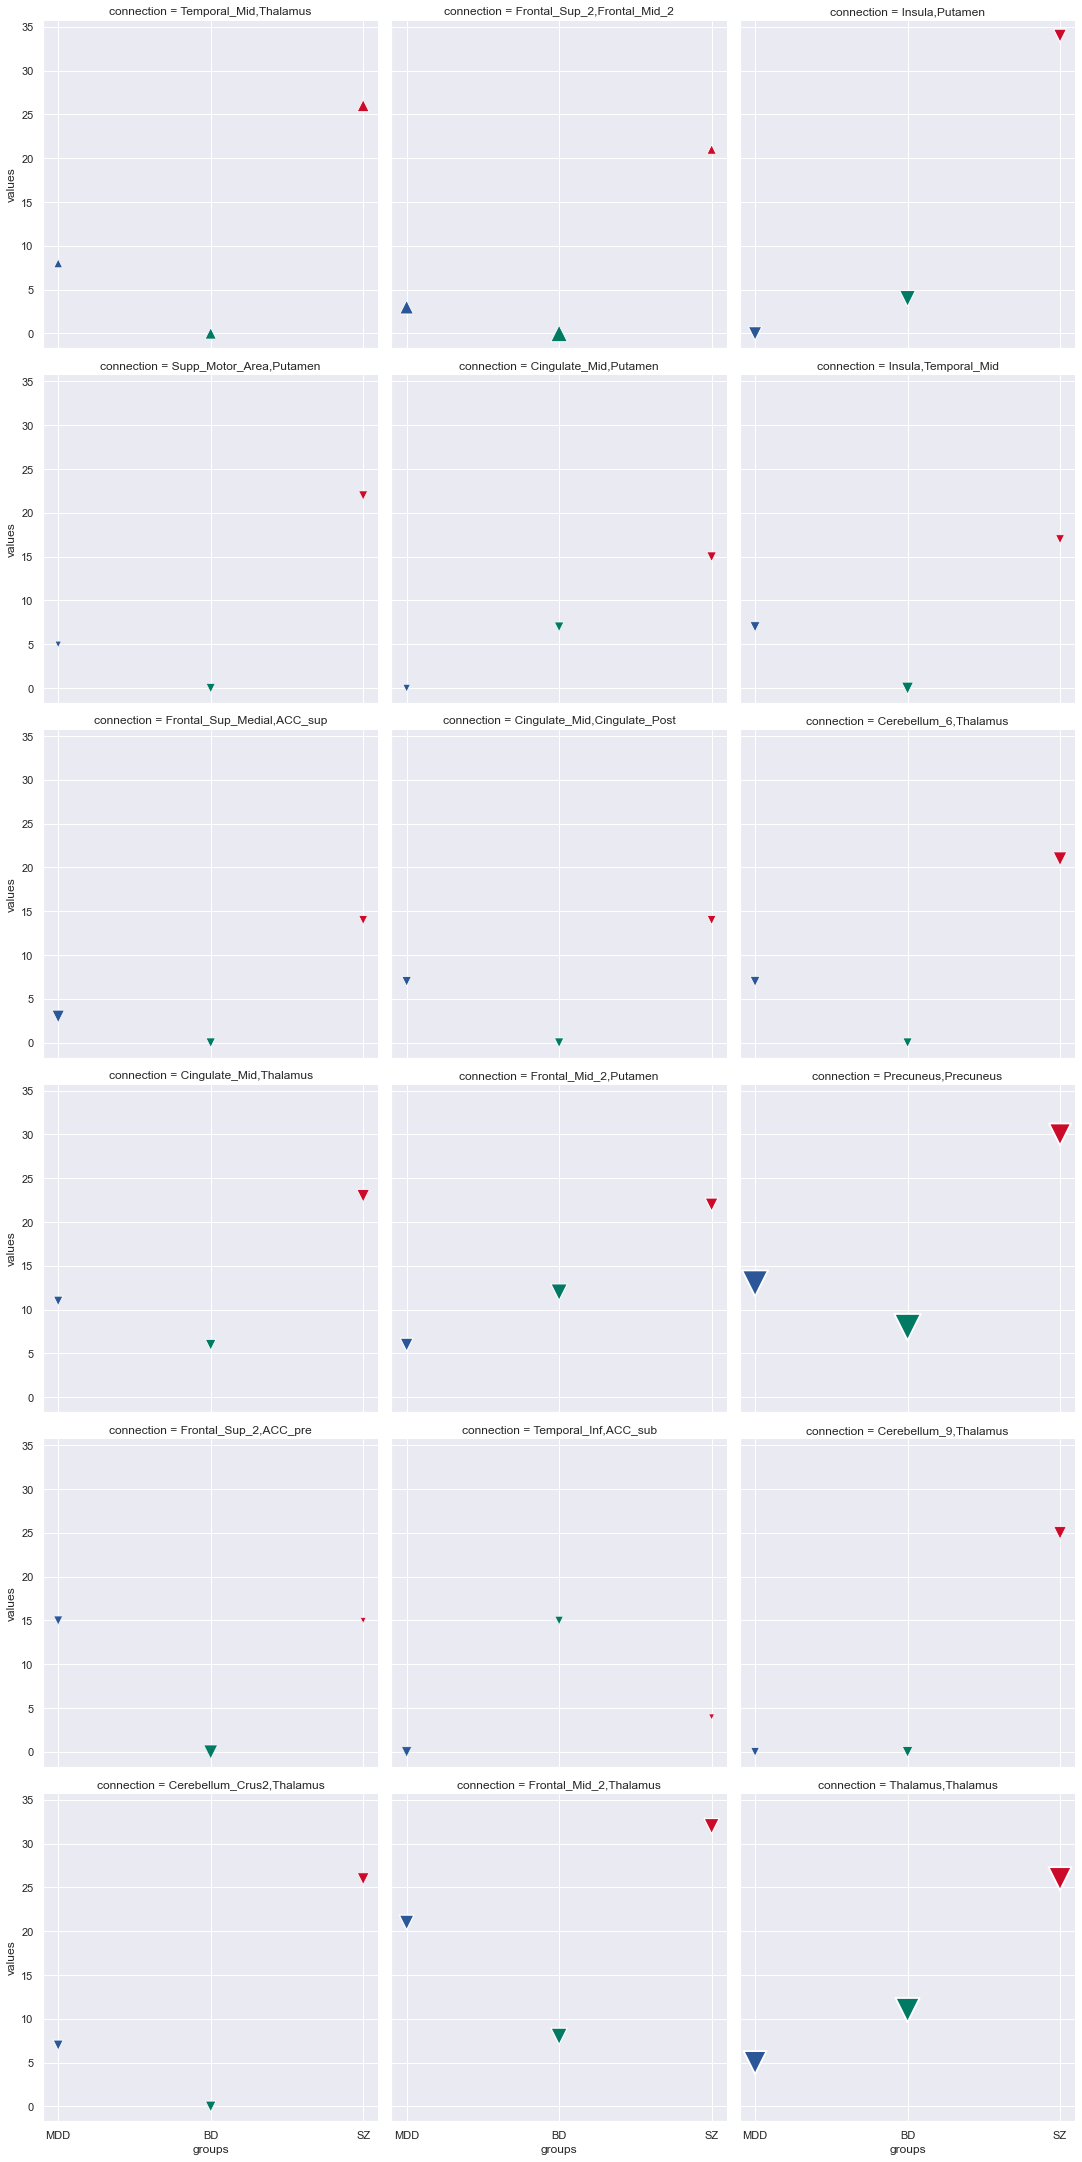

In [90]:
interaction_recap = networks_combinations.loc[connexion_df.aal3, 'interacType']
studies_percentage_connexions = studies_percentage.loc[connexion_df.aal3]

studies_perc_melt = studies_percentage_connexions.loc[:, (slice(None), [interacType[1],interacType[2]])].unstack().reset_index()
studies_perc_melt.columns = ['groups', 'interaction', 'connection', 'values']
studies_perc_melt_bool = studies_perc_melt.apply(lambda row: row.interaction == interaction_recap[row.connection], axis=1)
studies_perc_melt_filtered = studies_perc_melt[studies_perc_melt_bool]

size_df = studies_percentage.xs('Tested',level=1, axis=1).unstack().reset_index()
size_df.columns = ['groups', 'connection', 'values_size']
studies_perc_melt_data = pd.merge(studies_perc_melt_filtered, size_df, on= ['groups','connection'])

fig = sns.relplot(x = 'groups', y= 'values', data= studies_perc_melt_data, style='interaction',hue='groups',
            size=studies_perc_melt_data['values_size'].apply(np.square),
            col= 'connection', col_wrap=3, kind= 'scatter', markers=['^','v'], sizes=(30,700), palette= diagColors,
            legend = False)


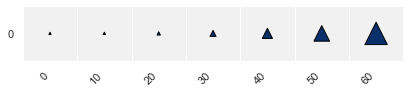

In [91]:
tested = studies_percentage.xs('Tested',level=1, axis=1)
tested_max = int(math.ceil(tested.max().max()/10)+1)*10
tested_min = int(math.floor(tested.min().min()/10))*10
tested_range = np.arange(tested_min,tested_max, 10)
tested_size_range = list(map(lambda x:x**2,tested_range))
tested_data = pd.DataFrame(data= zip(tested_range,tested_size_range), columns = ['value','size'])

fig,axs = plt.subplots(1,2,figsize=(15,1))
fig.delaxes(axs[1])
plot.heatmap(x = tested_data['value'],
             y =[0]*len(tested_data['value']),
             ax = axs[0],
             size = tested_data['size'].apply(np.square),
             marker = '^',
             linestyle ='-',
             )